In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt
import random

# Set seeds for reproducible results
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.3.0+cu118


## Reinforcement Learning
### Markov Decision Process (MDP)
**An MDP consists of:**
- **States (S)**: All possible situations the agent can be in
- **Actions (A)**: All possible moves the agent can make
- **Transitions (P)**: Probability of moving from one state to another: P(s'|s,a)
- **Rewards (R)**: Immediate reward received after taking action a in state s
- **Discount factor (γ)**: How much we care about future vs immediate rewards (0 < γ < 1)

**Think of it like a board game where:**
- States = positions on the board
- Actions = possible moves
- Rewards = points you get for reaching certain positions

In [101]:
def create_simple_gridworld():
    """
    Create a simple 4x4 grid world to understand MDP concepts
    
    Grid layout:
    [S] [ ] [ ] [ ]
    [ ] [ ] [ ] [ ]  
    [ ] [ ] [ ] [ ]
    [ ] [ ] [ ] [G]
    
    S = Start position (0,0)
    G = Goal position (3,3)
    Agent gets +10 reward for reaching goal, -0.1 for each step
    """
    
    # Grid world parameters
    grid_size = 4
    start_position = (0, 0)  # Top-left corner
    goal_position = (3, 3)   # Bottom-right corner
    
    # Actions: 0=up, 1=right, 2=down, 3=left
    actions = ['up', 'right', 'down', 'left']
    action_effects = [(-1, 0), (0, 1), (1, 0), (0, -1)]  # (row_change, col_change)
    
    print("=== GRID WORLD MDP ===")
    print(f"Grid size: {grid_size}x{grid_size}")
    print(f"Start position: {start_position}")
    print(f"Goal position: {goal_position}")
    print(f"Actions available: {actions}")
    print("Rewards: +10 for reaching goal, -0.1 for each step")
    
    return grid_size, start_position, goal_position, actions, action_effects


In [102]:
# Create our grid world
grid_size, start_pos, goal_pos, actions, action_effects = create_simple_gridworld()

=== GRID WORLD MDP ===
Grid size: 4x4
Start position: (0, 0)
Goal position: (3, 3)
Actions available: ['up', 'right', 'down', 'left']
Rewards: +10 for reaching goal, -0.1 for each step


In [103]:
def is_valid_position(position, grid_size):
    """Check if a position is within the grid boundaries"""
    row, col = position
    return 0 <= row < grid_size and 0 <= col < grid_size

In [104]:
def get_next_position(current_pos, action, action_effects, grid_size):
    """
    Calculate next position after taking an action
    If the move would go outside the grid, stay in the same position
    """
    row, col = current_pos
    drow, dcol = action_effects[action]
    
    new_position = (row + drow, col + dcol)
    
    # Check if new position is valid
    if is_valid_position(new_position, grid_size):
        return new_position
    else:
        return current_pos  # Stay in place if invalid move

In [105]:
def get_reward(position, goal_pos):
    """Calculate reward for being in a position"""
    if position == goal_pos:
        return 10.0  # Big reward for reaching goal
    else:
        return -0.1  # Small penalty for each step (encourages shorter paths)


In [106]:
test_pos = (3, 2)
print(f"Current position: {test_pos}")

for i, action_name in enumerate(actions):
    next_pos = get_next_position(test_pos, i, action_effects, grid_size)
    reward = get_reward(next_pos, goal_pos)
    print(f"Action '{action_name}' -> Position {next_pos}, Reward: {reward}")


Current position: (3, 2)
Action 'up' -> Position (2, 2), Reward: -0.1
Action 'right' -> Position (3, 3), Reward: 10.0
Action 'down' -> Position (3, 2), Reward: -0.1
Action 'left' -> Position (3, 1), Reward: -0.1


### Value Functions - How Good is Each State?

<p>The Value Function V(s) tells us how good it is to be in state s. It represents the expected total reward we'll get starting from state s and following our policy.</p>

<p>In simple terms:

Value of current state = Expected immediate reward + Discounted value of next states</p>

In [107]:
def initialize_value_function(grid_size):
    """Initialize value function for all states to zero"""
    # Create a 2D array to store values for each grid position
    values = np.zeros((grid_size, grid_size))
    print(f"Initialized value function with shape {values.shape}")
    return values

In [108]:
def calculate_state_value(position, values, action_effects, grid_size, goal_pos, gamma=0.9):
    """
    Calculate the value of a single state using Bellman equation
    
    For each possible action:
    1. Find where we'd end up
    2. Get the immediate reward
    3. Add discounted future value
    4. Take the maximum over all actions (optimal policy)
    """
    if position == goal_pos:
        return 0.0  # Goal state has no future value needed
    
    action_values = []
    
    # Try each possible action
    for action in range(len(action_effects)):
        # Where would we end up?
        next_pos = get_next_position(position, action, action_effects, grid_size)
        
        # What reward do we get?
        immediate_reward = get_reward(next_pos, goal_pos)
        
        # What's the future value?
        future_value = values[next_pos[0], next_pos[1]]
        
        # Total expected value for this action
        total_value = immediate_reward + gamma * future_value
        action_values.append(total_value)
    
    # Return the best possible value (maximum over actions)
    return max(action_values)

In [109]:
def perform_value_iteration(grid_size, goal_pos, action_effects, max_iterations=100, gamma=0.9):
    """
    Perform Value Iteration to find optimal state values
    
    Algorithm:
    1. Initialize all values to zero
    2. Repeat until convergence:
       - For each state, calculate new value using Bellman equation
       - Update the value
    3. Stop when values don't change much
    """    
    values = initialize_value_function(grid_size)
    convergence_threshold = 1e-6
    
    for iteration in range(max_iterations):
        old_values = values.copy()
        
        # Update value for each state
        for row in range(grid_size):
            for col in range(grid_size):
                position = (row, col)
                values[row, col] = calculate_state_value(
                    position, old_values, action_effects, grid_size, goal_pos, gamma
                )
        
        # Check for convergence
        max_change = np.max(np.abs(values - old_values))
        
        if iteration % 10 == 0:  # Print progress every 10 iterations
            print(f"Iteration {iteration:2d}: Max value change = {max_change:.6f}")
        
        if max_change < convergence_threshold:
            print(f"Converged after {iteration + 1} iterations!")
            break
    
    return values

In [110]:
optimal_values = perform_value_iteration(grid_size, goal_pos, action_effects)
optimal_values

Initialized value function with shape (4, 4)
Iteration  0: Max value change = 10.000000
Converged after 7 iterations!


array([[ 5.49539,  6.2171 ,  7.019  ,  7.91   ],
       [ 6.2171 ,  7.019  ,  7.91   ,  8.9    ],
       [ 7.019  ,  7.91   ,  8.9    , 10.     ],
       [ 7.91   ,  8.9    , 10.     ,  0.     ]])

In [111]:
def extract_optimal_policy(values, action_effects, grid_size, goal_pos, gamma=0.9):
    """
    Extract the optimal policy from the value function

    For each state, choose the action that leads to the highest expected value
    """
    policy = np.zeros((grid_size, grid_size), dtype=int)

    for row in range(grid_size):
        for col in range(grid_size):
            position = (row, col)
            
            if position == goal_pos:
                policy[row, col] = 0  # Arbitrary action at goal
                continue
            
            action_values = []
            
            # Calculate value for each action
            for action in range(len(action_effects)):
                next_pos = get_next_position(position, action, action_effects, grid_size)
                immediate_reward = get_reward(next_pos, goal_pos)
                future_value = values[next_pos[0], next_pos[1]]
                total_value = immediate_reward + gamma * future_value
                action_values.append(total_value)
            
            # Choose action with highest value
            best_action = np.argmax(action_values)
            policy[row, col] = best_action

    return policy

In [112]:
optimal_policy = extract_optimal_policy(optimal_values, action_effects, grid_size, goal_pos)
optimal_policy

array([[1, 1, 1, 2],
       [1, 1, 1, 2],
       [1, 1, 1, 2],
       [1, 1, 1, 0]])

In [113]:
action_names = ['up', 'right', 'down', 'left']
for row in range(grid_size):
    policy_row = []
    for col in range(grid_size):
        if (row, col) == goal_pos:
            policy_row.append("GOAL")
        else:
            action_idx = optimal_policy[row, col]
            policy_row.append(action_names[action_idx])
    print(policy_row)

['right', 'right', 'right', 'down']
['right', 'right', 'right', 'down']
['right', 'right', 'right', 'down']
['right', 'right', 'right', 'GOAL']


In [114]:
def visualize_value_function_and_policy(values, policy, grid_size, goal_pos):
    """Create visualizations of our results"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Value Function
    im1 = ax1.imshow(values, cmap='viridis', interpolation='nearest')
    ax1.set_title('Value Function\n(Brighter = Better States)', fontsize=14)
    ax1.set_xlabel('Column')
    ax1.set_ylabel('Row')
    
    # Add value numbers to each cell
    for i in range(grid_size):
        for j in range(grid_size):
            text = ax1.text(j, i, f'{values[i, j]:.2f}', 
                          ha='center', va='center', color='white', fontweight='bold')
    
    plt.colorbar(im1, ax=ax1, label='State Value')
    
    # Plot 2: Policy Visualization
    ax2.imshow(np.zeros_like(policy), cmap='gray', alpha=0.3)
    ax2.set_title('Optimal Policy\n(Arrows show best action)', fontsize=14)
    ax2.set_xlabel('Column')
    ax2.set_ylabel('Row')
    
    # Add policy arrows
    arrows = ['↑', '→', '↓', '←']
    for i in range(grid_size):
        for j in range(grid_size):
            if (i, j) == goal_pos:
                ax2.text(j, i, 'G', ha='center', va='center', 
                        fontsize=24, fontweight='bold', color='red')
                ax2.text(j, i-0.3, 'GOAL', ha='center', va='center', 
                        fontsize=8, fontweight='bold', color='red')
            else:
                arrow = arrows[policy[i, j]]
                ax2.text(j, i, arrow, ha='center', va='center', 
                        fontsize=20, fontweight='bold', color='blue')
    
    # Add grid lines
    for ax in [ax1, ax2]:
        ax.set_xticks(np.arange(-0.5, grid_size, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, grid_size, 1), minor=True)
        ax.grid(which='minor', color='gray', linestyle='-', linewidth=1)
        ax.set_xticks(range(grid_size))
        ax.set_yticks(range(grid_size))
    
    plt.tight_layout()
    plt.show()

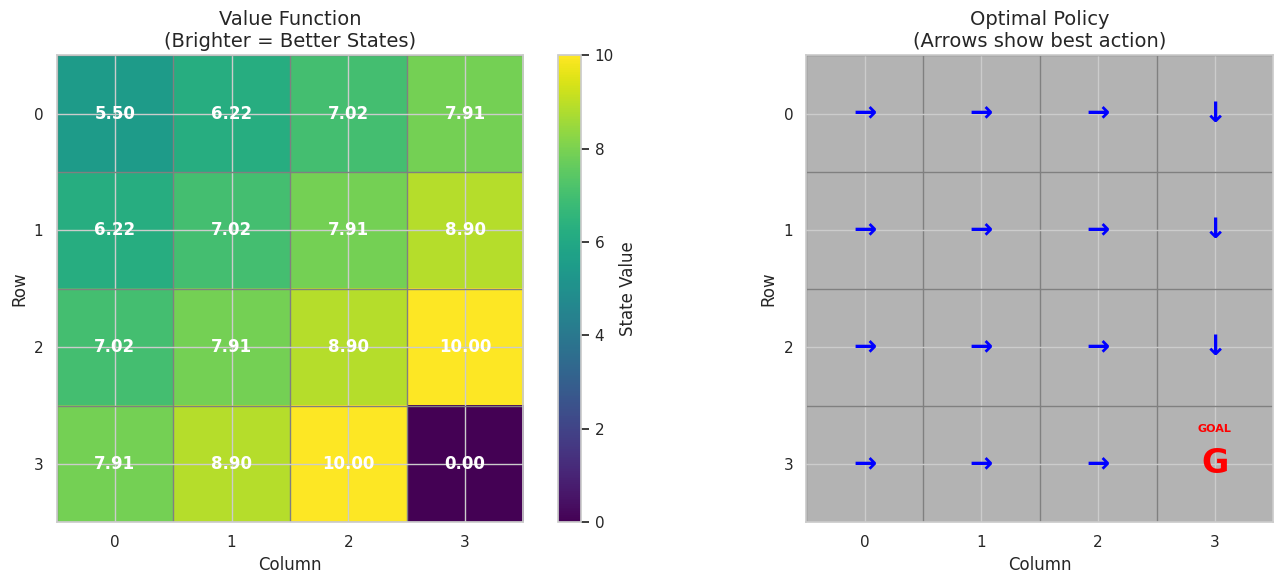

In [115]:
visualize_value_function_and_policy(optimal_values, optimal_policy, grid_size, goal_pos)

### Policy Gradient Methods

<p>Problem with Value-based methods:

- They work well for discrete, small action spaces
- Difficult for continuous actions (like steering a car)
- Always deterministic policies</p>

<p><b>Policy Gradient Solution:</b>

- Directly learn the policy π(a|s) using neural networks
- Can handle continuous action spaces
- Can learn stochastic (probabilistic) policies
- Use gradient ascent to maximize expected reward
</p>

In [116]:
def create_policy_network(input_size, hidden_size, output_size):
    """
    Create a simple neural network for policy
    
    Input: State representation (e.g., position coordinates)
    Output: Probability distribution over actions
    """
    print(f"Input size: {input_size} (state features)")
    print(f"Hidden size: {hidden_size} (neural network neurons)")
    print(f"Output size: {output_size} (number of actions)")
    
    # Create network layers
    layer1 = nn.Linear(input_size, hidden_size)
    layer2 = nn.Linear(hidden_size, hidden_size)
    layer3 = nn.Linear(hidden_size, output_size)
    
    # Group layers together
    network = nn.Sequential(
        layer1,
        nn.ReLU(),
        nn.Dropout(0.2),
        layer2,
        nn.ReLU(),
        nn.Dropout(0.2),
        layer3,
        nn.Softmax(dim=-1)  # Convert to probabilities
    )
    
    print("Policy network created successfully!")
    return network

In [117]:
def get_action_from_policy(network, state):
    """
    Get an action from our policy network
    
    Steps:
    1. Convert state to tensor
    2. Forward pass through network to get action probabilities
    3. Sample an action from the probability distribution
    4. Return action and its log probability (needed for learning)
    """
    # Convert state to PyTorch tensor
    state_tensor = torch.FloatTensor(state).unsqueeze(0)  # Add batch dimension
    
    # Get action probabilities
    with torch.no_grad():  # No gradients needed for action selection
        action_probs = network(state_tensor)
    
    # Create categorical distribution and sample
    dist = Categorical(action_probs)
    action = dist.sample()
    log_prob = dist.log_prob(action)
    
    return action.item(), log_prob

In [118]:
# Create and test policy network
state_size = 2  # We'll represent state as (row, col) normalized
hidden_size = 64
action_size = 4  # 4 possible actions in grid world

policy_net = create_policy_network(state_size, hidden_size, action_size)
policy_net


Input size: 2 (state features)
Hidden size: 64 (neural network neurons)
Output size: 4 (number of actions)
Policy network created successfully!


Sequential(
  (0): Linear(in_features=2, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=64, out_features=4, bias=True)
  (7): Softmax(dim=-1)
)

In [119]:
test_state = np.array([0.25, 0.25])  # Normalized position (1,1) in 4x4 grid
action, log_prob = get_action_from_policy(policy_net, test_state)
print(f"\nTest: State {test_state} -> Action {action} ({actions[action]})")
print(f"Log probability: {log_prob.item():.4f}")



Test: State [0.25 0.25] -> Action 0 (up)
Log probability: -1.3271


In [120]:
def normalize_state(position, grid_size):
    """Convert grid position to normalized coordinates for neural network"""
    row, col = position
    return np.array([row / (grid_size - 1), col / (grid_size - 1)])

In [121]:
def simulate_episode(policy_net, start_pos, goal_pos, grid_size, action_effects, max_steps=50):
    """
    Simulate one episode using current policy
    
    Returns:
    - states: List of states visited
    - actions: List of actions taken  
    - rewards: List of rewards received
    - log_probs: List of log probabilities (needed for learning)
    """
    print(f"\n--- Simulating Episode ---")
    
    # Initialize episode data
    states = []
    actions = []
    rewards = []
    log_probs = []
    
    # Start episode
    current_pos = start_pos
    
    for step in range(max_steps):
        # Convert position to normalized state
        state = normalize_state(current_pos, grid_size)
        states.append(state)
        
        # Get action from policy
        action, log_prob = get_action_from_policy(policy_net, state)
        actions.append(action)
        log_probs.append(log_prob)
        
        # Take action in environment
        next_pos = get_next_position(current_pos, action, action_effects, grid_size)
        reward = get_reward(next_pos, goal_pos)
        rewards.append(reward)
        
        print(f"Step {step}: {current_pos} -> {actions[step]} -> {next_pos} (reward: {reward})")
        
        # Update position
        current_pos = next_pos
        
        # Check if episode is done
        if current_pos == goal_pos:
            print(f"Reached goal in {step + 1} steps!")
            break
    
    return states, actions, rewards, log_probs

In [122]:
test_states, test_actions, test_rewards, test_log_probs = simulate_episode(
    policy_net, start_pos, goal_pos, grid_size, action_effects
)


--- Simulating Episode ---
Step 0: (0, 0) -> 0 -> (0, 0) (reward: -0.1)
Step 1: (0, 0) -> 3 -> (0, 0) (reward: -0.1)
Step 2: (0, 0) -> 0 -> (0, 0) (reward: -0.1)
Step 3: (0, 0) -> 0 -> (0, 0) (reward: -0.1)
Step 4: (0, 0) -> 0 -> (0, 0) (reward: -0.1)
Step 5: (0, 0) -> 3 -> (0, 0) (reward: -0.1)
Step 6: (0, 0) -> 2 -> (1, 0) (reward: -0.1)
Step 7: (1, 0) -> 0 -> (0, 0) (reward: -0.1)
Step 8: (0, 0) -> 0 -> (0, 0) (reward: -0.1)
Step 9: (0, 0) -> 3 -> (0, 0) (reward: -0.1)
Step 10: (0, 0) -> 3 -> (0, 0) (reward: -0.1)
Step 11: (0, 0) -> 3 -> (0, 0) (reward: -0.1)
Step 12: (0, 0) -> 0 -> (0, 0) (reward: -0.1)
Step 13: (0, 0) -> 0 -> (0, 0) (reward: -0.1)
Step 14: (0, 0) -> 1 -> (0, 1) (reward: -0.1)
Step 15: (0, 1) -> 1 -> (0, 2) (reward: -0.1)
Step 16: (0, 2) -> 2 -> (1, 2) (reward: -0.1)
Step 17: (1, 2) -> 2 -> (2, 2) (reward: -0.1)
Step 18: (2, 2) -> 1 -> (2, 3) (reward: -0.1)
Step 19: (2, 3) -> 1 -> (2, 3) (reward: -0.1)
Step 20: (2, 3) -> 2 -> (3, 3) (reward: 10.0)
Reached goal in 

In [123]:
print(f"Total steps: {len(test_actions)}")
print(f"Total reward: {sum(test_rewards):.2f}")


Total steps: 21
Total reward: 8.00


In [124]:
def calculate_returns(rewards, gamma=0.99):
    """
    Calculate discounted returns (rewards-to-go) for each time step
    
    Return at time t = R_t + γ*R_{t+1} + γ²*R_{t+2} + ...
    
    This tells us the total discounted reward from each time step onward
    """
    returns = []
    running_return = 0
    
    # Calculate returns in reverse order (from end to beginning)
    for reward in reversed(rewards):
        running_return = reward + gamma * running_return
        returns.insert(0, running_return)  # Insert at beginning
    
    returns = np.array(returns)
    
    print(f"Rewards: {[f'{r:.2f}' for r in rewards]}")
    print(f"Returns: {[f'{r:.2f}' for r in returns]}")
    print(f"Gamma (discount factor): {gamma}")
    
    return returns

In [125]:
test_returns = calculate_returns(test_rewards, gamma=0.9)
test_returns

Rewards: ['-0.10', '-0.10', '-0.10', '-0.10', '-0.10', '-0.10', '-0.10', '-0.10', '-0.10', '-0.10', '-0.10', '-0.10', '-0.10', '-0.10', '-0.10', '-0.10', '-0.10', '-0.10', '-0.10', '-0.10', '10.00']
Returns: ['0.34', '0.49', '0.65', '0.83', '1.04', '1.26', '1.52', '1.80', '2.11', '2.45', '2.84', '3.26', '3.74', '4.26', '4.85', '5.50', '6.22', '7.02', '7.91', '8.90', '10.00']
Gamma (discount factor): 0.9


array([ 0.3373432 ,  0.48593689,  0.65104099,  0.83448999,  1.03832221,
        1.26480245,  1.51644717,  1.79605241,  2.1067249 ,  2.45191656,
        2.83546284,  3.26162538,  3.73513931,  4.2612659 ,  4.845851  ,
        5.49539   ,  6.2171    ,  7.019     ,  7.91      ,  8.9       ,
       10.        ])

In [126]:
def reinforce_update(policy_net, log_probs, returns, learning_rate=0.01):
    """
    Update policy using REINFORCE algorithm
    
    REINFORCE Rule: θ = θ + α * ∇_θ[log π(a|s,θ) * G_t]
    
    Where:
    - θ = policy parameters
    - α = learning rate  
    - G_t = return (discounted future reward)
    - log π(a|s,θ) = log probability of action taken
    """
    # Convert returns to tensor and normalize (helps with training stability)
    returns_tensor = torch.FloatTensor(returns)
    returns_normalized = (returns_tensor - returns_tensor.mean()) / (returns_tensor.std() + 1e-8)
    
    # Calculate policy loss
    policy_loss = []
    for log_prob, G_t in zip(log_probs, returns_normalized):
        # REINFORCE: -log_prob * return (negative because we minimize loss)
        policy_loss.append(-log_prob * G_t)
    
    policy_loss = torch.stack(policy_loss).sum()
    
    print(f"Policy loss: {policy_loss.item():.4f}")
    
    # Create optimizer
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    
    # Gradient descent step
    optimizer.zero_grad()
    # policy_loss.backward()
    optimizer.step()
    
    print("Policy updated!")
    return policy_loss.item()

In [127]:
loss = reinforce_update(policy_net, test_log_probs, test_returns)
loss

Policy loss: -0.5859
Policy updated!


-0.585920512676239

In [128]:
def train_policy_with_reinforce(policy_net, start_pos, goal_pos, grid_size, action_effects, 
                               num_episodes=200, learning_rate=0.001, gamma=0.99):
    """
    Train policy using REINFORCE algorithm
    """  
    # Create optimizer
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    
    # Track training progress
    episode_rewards = []
    episode_lengths = []
    policy_losses = []
    
    for episode in range(num_episodes):
        # Simulate episode
        states, actions, rewards, log_probs = simulate_episode(
            policy_net, start_pos, goal_pos, grid_size, action_effects, max_steps=20
        )
        
        # Calculate returns
        returns = calculate_returns(rewards, gamma)
        
        # Update policy
        returns_tensor = torch.FloatTensor(returns)
        returns_normalized = (returns_tensor - returns_tensor.mean()) / (returns_tensor.std() + 1e-8)
        
        # Calculate loss
        policy_loss = []
        for log_prob, G_t in zip(log_probs, returns_normalized):
            policy_loss.append(-log_prob * G_t)
        policy_loss = torch.stack(policy_loss).sum()
        
        # Gradient update
        optimizer.zero_grad()
        # policy_loss.backward()
        optimizer.step()
        
        # Record metrics
        total_reward = sum(rewards)
        episode_length = len(actions)
        
        episode_rewards.append(total_reward)
        episode_lengths.append(episode_length)
        policy_losses.append(policy_loss.item())
        
        # Print progress
        if (episode + 1) % 25 == 0:
            avg_reward = np.mean(episode_rewards[-25:])
            avg_length = np.mean(episode_lengths[-25:])
            print(f"Episode {episode + 1:3d} | Avg Reward: {avg_reward:6.2f} | "
                  f"Avg Length: {avg_length:5.1f} | Loss: {policy_loss.item():7.4f}")
    
    return episode_rewards, episode_lengths, policy_losses

In [129]:
rewards_history, lengths_history, losses_history = train_policy_with_reinforce(
    policy_net, start_pos, goal_pos, grid_size, action_effects, num_episodes=150
)


--- Simulating Episode ---
Step 0: (0, 0) -> 2 -> (1, 0) (reward: -0.1)
Step 1: (1, 0) -> 3 -> (1, 0) (reward: -0.1)
Step 2: (1, 0) -> 1 -> (1, 1) (reward: -0.1)
Step 3: (1, 1) -> 1 -> (1, 2) (reward: -0.1)
Step 4: (1, 2) -> 1 -> (1, 3) (reward: -0.1)
Step 5: (1, 3) -> 2 -> (2, 3) (reward: -0.1)
Step 6: (2, 3) -> 2 -> (3, 3) (reward: 10.0)
Reached goal in 7 steps!
Rewards: ['-0.10', '-0.10', '-0.10', '-0.10', '-0.10', '-0.10', '10.00']
Returns: ['8.83', '9.02', '9.21', '9.41', '9.60', '9.80', '10.00']
Gamma (discount factor): 0.99

--- Simulating Episode ---
Step 0: (0, 0) -> 3 -> (0, 0) (reward: -0.1)
Step 1: (0, 0) -> 0 -> (0, 0) (reward: -0.1)
Step 2: (0, 0) -> 2 -> (1, 0) (reward: -0.1)
Step 3: (1, 0) -> 3 -> (1, 0) (reward: -0.1)
Step 4: (1, 0) -> 0 -> (0, 0) (reward: -0.1)
Step 5: (0, 0) -> 3 -> (0, 0) (reward: -0.1)
Step 6: (0, 0) -> 1 -> (0, 1) (reward: -0.1)
Step 7: (0, 1) -> 0 -> (0, 1) (reward: -0.1)
Step 8: (0, 1) -> 3 -> (0, 0) (reward: -0.1)
Step 9: (0, 0) -> 1 -> (0, 1)

Step 1: (0, 0) -> 1 -> (0, 1) (reward: -0.1)
Step 2: (0, 1) -> 1 -> (0, 2) (reward: -0.1)
Step 3: (0, 2) -> 2 -> (1, 2) (reward: -0.1)
Step 4: (1, 2) -> 3 -> (1, 1) (reward: -0.1)
Step 5: (1, 1) -> 3 -> (1, 0) (reward: -0.1)
Step 6: (1, 0) -> 2 -> (2, 0) (reward: -0.1)
Step 7: (2, 0) -> 0 -> (1, 0) (reward: -0.1)
Step 8: (1, 0) -> 0 -> (0, 0) (reward: -0.1)
Step 9: (0, 0) -> 1 -> (0, 1) (reward: -0.1)
Step 10: (0, 1) -> 0 -> (0, 1) (reward: -0.1)
Step 11: (0, 1) -> 1 -> (0, 2) (reward: -0.1)
Step 12: (0, 2) -> 3 -> (0, 1) (reward: -0.1)
Step 13: (0, 1) -> 1 -> (0, 2) (reward: -0.1)
Step 14: (0, 2) -> 3 -> (0, 1) (reward: -0.1)
Step 15: (0, 1) -> 3 -> (0, 0) (reward: -0.1)
Step 16: (0, 0) -> 3 -> (0, 0) (reward: -0.1)
Step 17: (0, 0) -> 1 -> (0, 1) (reward: -0.1)
Step 18: (0, 1) -> 2 -> (1, 1) (reward: -0.1)
Step 19: (1, 1) -> 0 -> (0, 1) (reward: -0.1)
Rewards: ['-0.10', '-0.10', '-0.10', '-0.10', '-0.10', '-0.10', '-0.10', '-0.10', '-0.10', '-0.10', '-0.10', '-0.10', '-0.10', '-0.10',

In [130]:
def plot_training_results(rewards, lengths, losses):
    """Plot training progress"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Episode Rewards
    axes[0, 0].plot(rewards, alpha=0.7, color='blue')
    axes[0, 0].set_title('Episode Rewards Over Time')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Total Reward')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Moving Average Rewards  
    window = 20
    if len(rewards) >= window:
        moving_avg = []
        for i in range(window-1, len(rewards)):
            moving_avg.append(np.mean(rewards[i-window+1:i+1]))
        
        axes[0, 1].plot(range(window-1, len(rewards)), moving_avg, color='red', linewidth=2)
        axes[0, 1].set_title(f'Moving Average Rewards (window={window})')
        axes[0, 1].set_xlabel('Episode')
        axes[0, 1].set_ylabel('Average Reward')
        axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Episode Lengths
    axes[1, 0].plot(lengths, alpha=0.7, color='green')
    axes[1, 0].set_title('Episode Lengths (Steps to Goal)')
    axes[1, 0].set_xlabel('Episode')
    axes[1, 0].set_ylabel('Number of Steps')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Policy Losses
    axes[1, 1].plot(losses, alpha=0.7, color='orange')
    axes[1, 1].set_title('Policy Loss During Training')
    axes[1, 1].set_xlabel('Episode')
    axes[1, 1].set_ylabel('Loss Value')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n=== TRAINING SUMMARY ===")
    print(f"Final average reward (last 20 episodes): {np.mean(rewards[-20:]):.2f}")
    print(f"Final average length (last 20 episodes): {np.mean(lengths[-20:]):.1f}")
    print(f"Best episode reward: {max(rewards):.2f}")
    print(f"Shortest successful episode: {min(lengths)} steps")

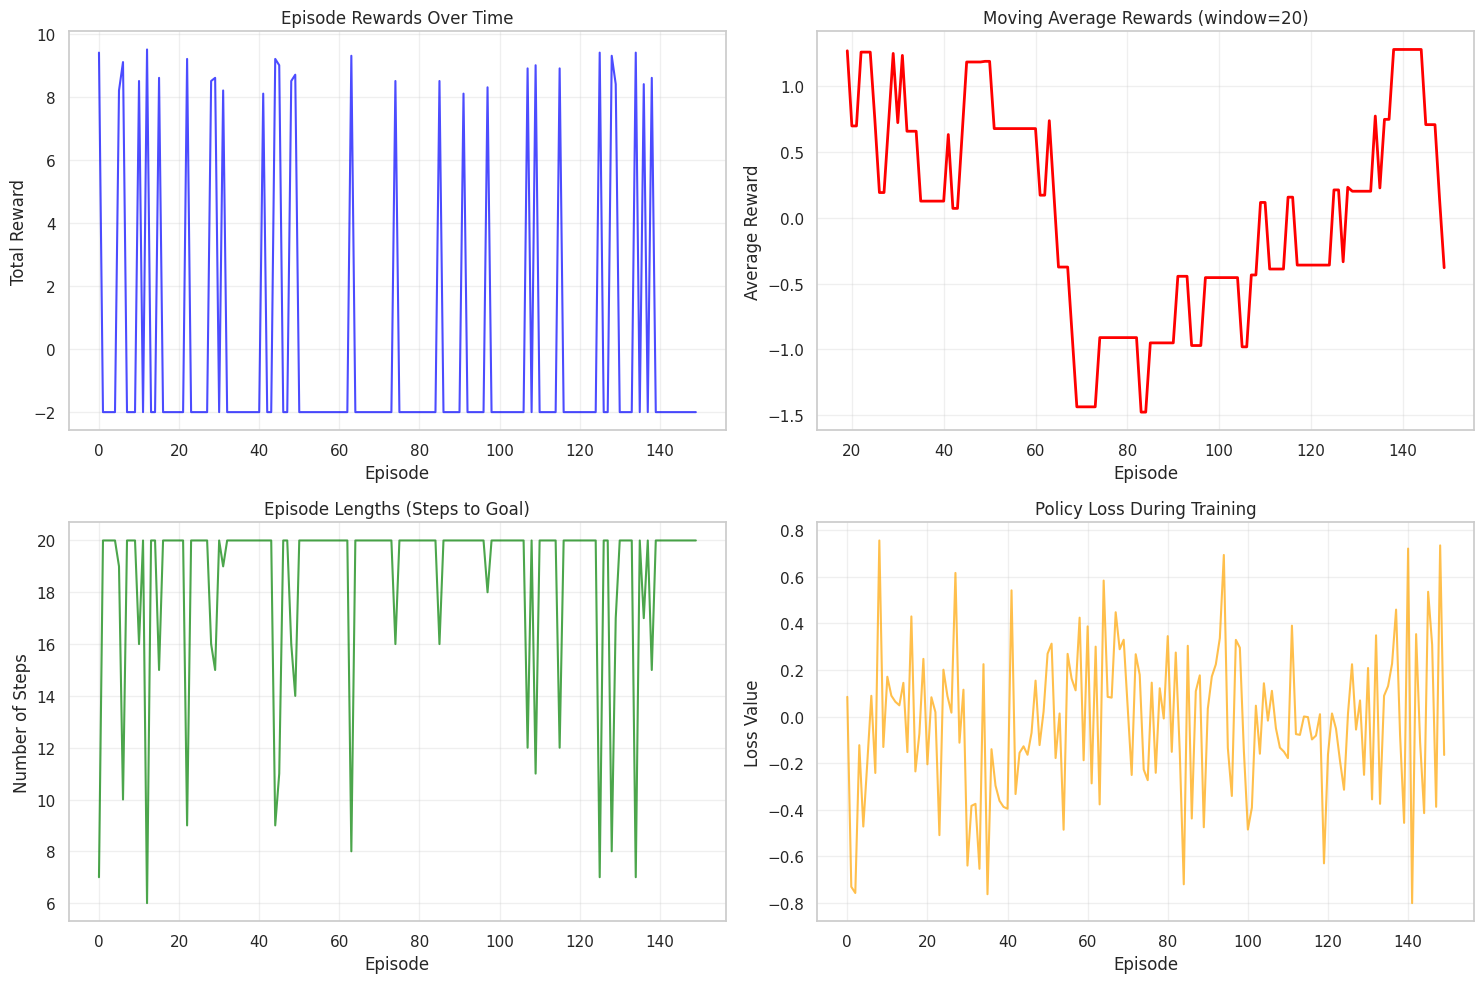


=== TRAINING SUMMARY ===
Final average reward (last 20 episodes): -0.38
Final average length (last 20 episodes): 18.9
Best episode reward: 9.50
Shortest successful episode: 6 steps


In [131]:
plot_training_results(rewards_history, lengths_history, losses_history)
